In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
np.random.seed(4589)

In [37]:
class ReLU:
    name = "ReLU"
    
    def __call__(self, z):
        return np.maximum(0, z)
    
    def derivative(self, z):
        return np.where(z > 0, 1.0, 0.0)

In [38]:
class MSE:
    name = "MSE"

    # x - predicted values, y - target values
    def __call__(self, y, x):
        return np.mean((y - x) ** 2)
    
    def derivative(self, y, x):
        return (-2/x.shape[1])*(y-x)

In [39]:
class DenseLayer:
    def __init__(self, input_size, num_neurons, activation, name="Billy"):
        self.input_size = input_size
        self.num_neurons = num_neurons
        self.name = name
        self.act = activation

        self.weights = None
        self.biases = None
        self.inputs = None
        self.z = None

    def __str__(self):
        return f"{self.name}: ({self.num_neurons}, {self.act.name})"

    def initialize(self, init_weights_mult):
        self.weights = (
            np.random.randn(self.input_size, self.num_neurons) * init_weights_mult
        )
        self.biases = np.zeros((1, self.num_neurons))

    def forward(self, inputs):
        self.inputs = inputs
        self.z = np.dot(self.inputs, self.weights) + self.biases
        activations = self.act(self.z)
        return activations

    def backward(self, output_error, learning_rate):
        dz = output_error * self.act.derivative(self.z)
        output_error_prev = np.dot(dz, self.weights.T)
        self.weights -= learning_rate * np.dot(self.inputs.T, dz)
        self.biases -= learning_rate * np.sum(dz, axis=0, keepdims=True)

        return output_error_prev

In [40]:
class Sequential:
    def __init__(
        self,
        layers=[],
        init_weights_mult=0.01,
        name="My Model",
    ):
        self.name = name
        self.layers = layers
        self.shape = [layer.num_neurons for layer in self.layers]
        self.init_weights_mult = init_weights_mult

        self.compile()

    def compile(self):
        self.layers[0].name = "L_1"
        self.layers[0].initialize(self.init_weights_mult)
        for i in range(1, len(self.layers)):
            if self.layers[i].input_size != self.layers[i-1].num_neurons:
                raise ValueError("Non-valid input shape.")
            self.layers[i].name = f"L_{i}"
            self.layers[i].initialize(self.init_weights_mult)

    def __str__(self):
        result = []

        result.append(
            f"{self.name}: "
            + " -> ".join(str(layer) for layer in self.layers)
            + "\n"
        )
        result.append(f"{'Layer':<10} {'Neurons':<10} {'Weights':<60} {'Biases':<30}")
        result.append("-" * 110)

        for i, layer in enumerate(self.layers):

            if layer.weights is None:
                formatted_weights = "None"
            else:
                weights_flat = layer.weights.flatten()
                if len(weights_flat) > 6:
                    first_three = ", ".join(
                        f"{weight:.4f}" for weight in weights_flat[:3]
                    )
                    last_three = ", ".join(
                        f"{weight:.4f}" for weight in weights_flat[-3:]
                    )
                    formatted_weights = f"{first_three}, ..., {last_three}"
                else:
                    formatted_weights = ", ".join(
                        f"{weight:.4f}" for weight in weights_flat
                    )

            if layer.biases is None:
                formatted_biases = "None"
            else:
                biases_flat = layer.biases.flatten()
                if len(biases_flat) > 4:
                    formatted_biases = (
                        ", ".join(f"{bias:.2f}" for bias in biases_flat[:4]) + ", ..."
                    )
                else:
                    formatted_biases = ", ".join(f"{bias:.2f}" for bias in biases_flat)

            result.append(
                f"{layer.name:<10} {layer.num_neurons:<10} {formatted_weights:<60} {formatted_biases:<30}"
            )

        return "\n" + "\n".join(result) + "\n"

    def forward(self, input_data):
        for layer in self.layers:
            input_data = layer.forward(input_data)
        return input_data

    def backward(self, output_error ,learning_rate):
        for layer in reversed(self.layers):
            output_error = layer.backward(output_error, learning_rate)

In [41]:
def train(
    model,
    train_data,
    train_labels,
    loss,
    learning_rate,
    batch_size,
    epochs,
    shuffle=True,
    make_plot = True
):
    if np.shape(train_data)[0] != np.shape(train_labels)[0]:
        raise ValueError("The number of training samples and labels must match.")

    input_size = train_data.shape[1] * train_data.shape[2]
    loss_history = np.zeros(epochs)
    pred_history = np.zeros(epochs)

    for e in range(epochs):
        if shuffle:
            indices = np.random.permutation(len(train_data))
            train_data = train_data[indices]
            train_labels = train_labels[indices]

        accumulated_error = np.zeros((1, 10))

        for i in range(len(train_data)):
            input = train_data[i].reshape((1, input_size))
            output = model.forward(input)

            predicted_label = np.argmax(output)
            if predicted_label == train_labels[i]:
                pred_history[e] += 1

            true_val = np.zeros((1, 10))
            true_val[0][train_labels[i]] = 1
            loss_history[e] += loss(y=true_val, x=output)

            accumulated_error += loss.derivative(y=true_val, x=output)

            if (i + 1) % batch_size == 0:
                model.backward(accumulated_error, learning_rate)
                accumulated_error = np.zeros((1, 10))
    
    if make_plot:
        fig, ax1 = plt.subplots()

        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Loss", color="coral")
        ax1.plot(loss_history, color="coral", label="Loss")
        ax1.set_ylim(0, 6000)

        ax2 = ax1.twinx()
        ax2.set_ylabel("Correct Predictions", color="green")
        ax2.plot(pred_history, color="green", label="Correct Predictions")
        ax2.set_ylim(0, 60000)

        plt.title("Training Loss and Accuracy Over Time")
        fig.tight_layout()
        plt.grid(True)
        plt.show()

In [42]:
def test(model, test_data, test_labels):
    right_ans = 0
    num_samples = len(test_data)

    for i in range(test_data.shape[0]):
        input_data = test_data[i].reshape((1, test_data.shape[1] * test_data.shape[2]))
        output = model.forward(input_data)

        predicted_label = np.argmax(output)
        if predicted_label == test_labels[i]:
            right_ans += 1

    accuracy = right_ans / num_samples if num_samples > 0 else 0.0
    print(f"Correct predictions: {right_ans}/{num_samples}")
    print(f"Accuracy: {accuracy:.3%}")

In [43]:
x_train = np.load("dataset/mnist_x_train.npy") / 255
y_train = np.load("dataset/mnist_y_train.npy") 
x_test = np.load("dataset/mnist_x_test.npy") / 255
y_test = np.load("dataset/mnist_y_test.npy")

In [44]:
my_model = Sequential(
    layers=[
        DenseLayer(input_size=784, num_neurons=64, activation=ReLU()),
        DenseLayer(input_size=64, num_neurons=32, activation=ReLU()),
        DenseLayer(input_size=32, num_neurons=10, activation=ReLU()),
    ],
    init_weights_mult=0.01,
)
print(my_model)


My Model: L_1: (64, ReLU) -> L_1: (32, ReLU) -> L_2: (10, ReLU)

Layer      Neurons    Weights                                                      Biases                        
--------------------------------------------------------------------------------------------------------------
L_1        64         0.0065, 0.0047, -0.0058, ..., 0.0055, -0.0069, 0.0112        0.00, 0.00, 0.00, 0.00, ...   
L_1        32         -0.0024, 0.0050, -0.0063, ..., -0.0038, -0.0156, 0.0082      0.00, 0.00, 0.00, 0.00, ...   
L_2        10         -0.0049, -0.0011, 0.0118, ..., 0.0158, -0.0054, 0.0119       0.00, 0.00, 0.00, 0.00, ...   



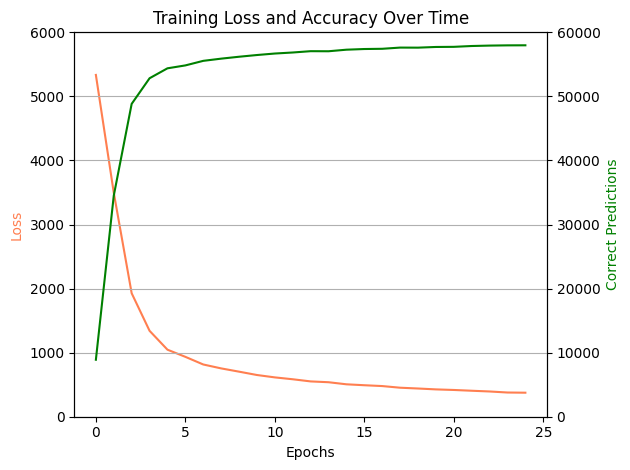


My Model: L_1: (64, ReLU) -> L_1: (32, ReLU) -> L_2: (10, ReLU)

Layer      Neurons    Weights                                                      Biases                        
--------------------------------------------------------------------------------------------------------------
L_1        64         0.0065, 0.0047, -0.0058, ..., 0.0055, -0.0069, 0.0112        -0.07, 0.16, 0.35, 0.13, ...  
L_1        32         0.2297, 0.2359, 0.0010, ..., -0.0849, -0.0158, -0.0137       0.32, 0.21, 0.02, 0.03, ...   
L_2        10         0.0677, -0.1896, -0.1732, ..., 0.1552, -0.1613, -0.4148      0.70, 0.67, 0.82, 0.75, ...   



In [45]:
train(
    model=my_model,
    train_data=x_train,
    train_labels=y_train,
    loss=MSE(),
    learning_rate=0.05,
    batch_size=10,
    epochs=25,
    shuffle = True,
    make_plot = True
)
print(my_model)

In [46]:
test(model=my_model, test_data=x_test, test_labels=y_test)

Correct predictions: 9640/10000
Accuracy: 96.400%
